***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        c=c+1
        print(c)
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        c=c+1
        print(c)
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)
df_html.head()

Shape of our dataset: (43491, 1433)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_ftp,a_href_https,a_href_irc,a_href_mailto,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,a_rel_designer,a_rel_detalis,a_rel_discussion,a_rel_dofollow,...,object_data_.svg,object_data_.swf,object_data_absolute,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,pro

In [6]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'functions' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)


df_js.drop(['js_function_Object.defineProperty(',
'js_function_Object.keys(',
'js_function_.substr',
'js_function_unescape(','number_of_cookies','number_of_non_http_only_cookies'],axis=1,inplace=True)
print("Shape of our dataset:",df_js.shape)
df_js.head()

Shape of our dataset: (43294, 400)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [ ]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)

### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)
df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

num_stats_js=num_stats(df_js,num_var_js)
cat_stats_js=cat_stats(df_js,cat_var_js)


num_stats_html=num_stats(df_html,num_var_html)
cat_stats_html=cat_stats(df_html,cat_var_html)

fin_col=num_stats_js.index.values[0:25].tolist()+cat_stats_js.index.values[0:25].tolist() + num_stats_html.index.values[0:25].tolist()+cat_stats_html.index.values[0:25].tolist() 

In [8]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 51)

In [9]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [10]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [11]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.871986980686
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27668   170    27838
True        3999   730     4729
__all__    31667   900    32567

Accuracy of the model for test data is: 0.864898059445
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6887    53     6940
True        1047   155     1202
__all__     7934   208     8142



Logistic Regression
Accuracy of the model for training data is: 0.88347099825
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24988  2850    27838
True         945  3784     4729
__all__    25933  6634    32567

Accuracy of the model for test data is: 0.885531810366
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6223   717     6940
True         215   987     1202
__all__     6438  1704     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.914269045353
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25247  2591    27838
True         201  4528     4729
__all__    25448  7119    32567

Accuracy of the model for test data is: 0.903095062638
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6272   668     6940
True         121  1081     1202
__all__     6393  1749     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.887708416495
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25031  2807    27838
True         850  3879     4729
__all__    25881  6686    32567

Accuracy of the model for test data is: 0.888233849177
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6227   713     6940
True         197  1005     1202
__all__     6424  1718     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8991310222
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25207  2631    27838
True         654  4075     4729
__all__    25861  6706    32567

Accuracy of the model for test data is: 0.898427904692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6274   666     6940
True         161  1041     1202
__all__     6435  1707     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.916602695981
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25251  2587    27838
True         129  4600     4729
__all__    25380  7187    32567

Accuracy of the model for test data is: 0.903217882584
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6274   666     6940
True         122  1080     1202
__all__     6396  1746     8142



Bagging Classifier
Accuracy of the model for training data is: 0.914422574999
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25221  2617    27838
True         170  4559     4729
__all__    25391  7176    32567

Accuracy of the model for test data is: 0.902358142962
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6257   683     6940
True         112  1090     1202
__all__     6369  1773     8142



Neural Network-1
The accuracy of the model on training data is: 0.875702398148


Predicted  False  True  __all__
Actual                         
False      27726   112    27838
True        3936   793     4729
__all__    31662   905    32567

The accuracy of the model on test data is: 0.862687300418


Predicted  False  True  __all__
Actual                         
False       6890    50     6940
True        1068   134     1202
__all__     7958   184     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [12]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [13]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871987,730.0,27668.0,170.0,3999.0,0.006107,0.845633
LogisticRegression,0.883471,3784.0,24988.0,2850.0,945.0,0.102378,0.199831
RandomForestClassifier,0.914269,4528.0,25247.0,2591.0,201.0,0.093074,0.042504
AdaBoostClassifier,0.887708,3879.0,25031.0,2807.0,850.0,0.100833,0.179742
GradientBoostingClassifier,0.899131,4075.0,25207.0,2631.0,654.0,0.094511,0.138296
ExtraTreeClassifier,0.916603,4600.0,25251.0,2587.0,129.0,0.092931,0.027278
BaggingClassifier,0.914423,4559.0,25221.0,2617.0,170.0,0.094008,0.035948
Neural Network-1,0.875702,793.0,27726.0,112.0,3936.0,0.004023,0.832311


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.864898,155.0,6887.0,53.0,1047.0,0.007637,0.871048,0.560657,0.272752
LogisticRegression,0.885532,987.0,6223.0,717.0,215.0,0.103314,0.178869,0.858909,0.625944
RandomForestClassifier,0.903095,1081.0,6272.0,668.0,121.0,0.096254,0.100666,0.901540,0.693656
AdaBoostClassifier,0.888234,1005.0,6227.0,713.0,197.0,0.102738,0.163894,0.866684,0.637588
GradientBoostingClassifier,0.898428,1041.0,6274.0,666.0,161.0,0.095965,0.133943,0.885046,0.671094
ExtraTreeClassifier,0.903218,1080.0,6274.0,666.0,122.0,0.095965,0.101498,0.901269,0.693619
BaggingClassifier,0.902358,1090.0,6257.0,683.0,112.0,0.098415,0.093178,0.904203,0.694820
Neural Network-1,0.862687,134.0,6890.0,50.0,1068.0,0.007205,0.888519,0.904203,0.248889


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [14]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [15]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [16]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [17]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.928910122854
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24466   3372    27838
True         586  27252    27838
__all__    25052  30624    55676

Accuracy of the model for test data is: 0.878653893392
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6035   905     6940
True          83  1119     1202
__all__     6118  2024     8142



Logistic Regression
Accuracy of the model for training data is: 0.885552122997
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22800   5038    27838
True        1334  26504    27838
__all__    24134  31542    55676

Accuracy of the model for test data is: 0.83677229182
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5681  1259     6940
True          70  1132     1202
__all__     5751  2391     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.947877002658
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25074   2764    27838
True         138  27700    27838
__all__    25212  30464    55676

Accuracy of the model for test data is: 0.900147383935
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6221   719     6940
True          94  1108     1202
__all__     6315  1827     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.904680652346
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23718   4120    27838
True        1187  26651    27838
__all__    24905  30771    55676

Accuracy of the model for test data is: 0.866003438958
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5929  1011     6940
True          80  1122     1202
__all__     6009  2133     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.922857245492
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24225   3613    27838
True         682  27156    27838
__all__    24907  30769    55676

Accuracy of the model for test data is: 0.877548513879
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6026   914     6940
True          83  1119     1202
__all__     6109  2033     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.948613406135
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25080   2758    27838
True         103  27735    27838
__all__    25183  30493    55676

Accuracy of the model for test data is: 0.899287644313
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6227   713     6940
True         107  1095     1202
__all__     6334  1808     8142



Bagging Classifier
Accuracy of the model for training data is: 0.947697392054
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25054   2784    27838
True         128  27710    27838
__all__    25182  30494    55676

Accuracy of the model for test data is: 0.896831245394
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6192   748     6940
True          92  1110     1202
__all__     6284  1858     8142



Neural Network-1
The accuracy of the model on training data is: 0.93776492565


Predicted  False   True  __all__
Actual                          
False      24480   3358    27838
True         107  27731    27838
__all__    24587  31089    55676

The accuracy of the model on test data is: 0.880127732744


Predicted  False  True  __all__
Actual                         
False       6034   906     6940
True          70  1132     1202
__all__     6104  2038     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [18]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [19]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.928910,27252.0,24466.0,3372.0,586.0,0.121129,0.021050
LogisticRegression,0.885552,26504.0,22800.0,5038.0,1334.0,0.180976,0.047920
RandomForestClassifier,0.947877,27700.0,25074.0,2764.0,138.0,0.099289,0.004957
AdaBoostClassifier,0.904681,26651.0,23718.0,4120.0,1187.0,0.147999,0.042640
GradientBoostingClassifier,0.922857,27156.0,24225.0,3613.0,682.0,0.129787,0.024499
ExtraTreeClassifier,0.948613,27735.0,25080.0,2758.0,103.0,0.099073,0.003700
BaggingClassifier,0.947697,27710.0,25054.0,2784.0,128.0,0.100007,0.004598
Neural Network-1,0.937765,27731.0,24480.0,3358.0,107.0,0.120626,0.003844


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.878654,1119.0,6035.0,905.0,83.0,0.130403,0.069052,0.900272,0.657064
LogisticRegression,0.836772,1132.0,5681.0,1259.0,70.0,0.181412,0.058236,0.880176,0.592223
RandomForestClassifier,0.900147,1108.0,6221.0,719.0,94.0,0.103602,0.078203,0.909097,0.695717
AdaBoostClassifier,0.866003,1122.0,5929.0,1011.0,80.0,0.145677,0.066556,0.893884,0.635526
GradientBoostingClassifier,0.877549,1119.0,6026.0,914.0,83.0,0.131700,0.069052,0.899624,0.655028
ExtraTreeClassifier,0.899288,1095.0,6227.0,713.0,107.0,0.102738,0.089018,0.904122,0.689821
BaggingClassifier,0.896831,1110.0,6192.0,748.0,92.0,0.107781,0.076539,0.907840,0.689463
Neural Network-1,0.880128,1132.0,6034.0,906.0,70.0,0.130548,0.058236,0.907840,0.664292


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [20]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [21]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9458, 50)


In [22]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [23]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.561323747092
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4585   144     4729
True        4005   724     4729
__all__     8590   868     9458

Accuracy of the model for test data is: 0.832596413658
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6621   319     6940
True        1044   158     1202
__all__     7665   477     8142



Logistic Regression
Accuracy of the model for training data is: 0.87904419539
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3843   886     4729
True         258  4471     4729
__all__     4101  5357     9458

Accuracy of the model for test data is: 0.833578973225
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5654  1286     6940
True          69  1133     1202
__all__     5723  2419     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.943011207443
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4252   477     4729
True          62  4667     4729
__all__     4314  5144     9458

Accuracy of the model for test data is: 0.886514369934
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6098   842     6940
True          82  1120     1202
__all__     6180  1962     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.89120321421
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3977   752     4729
True         277  4452     4729
__all__     4254  5204     9458

Accuracy of the model for test data is: 0.857897322525
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5854  1086     6940
True          71  1131     1202
__all__     5925  2217     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.910234721929
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4073   656     4729
True         193  4536     4729
__all__     4266  5192     9458

Accuracy of the model for test data is: 0.869073937607
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5935  1005     6940
True          61  1141     1202
__all__     5996  2146     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.947240431381
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4257   472     4729
True          27  4702     4729
__all__     4284  5174     9458

Accuracy of the model for test data is: 0.889707688529
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6133   807     6940
True          91  1111     1202
__all__     6224  1918     8142



Bagging Classifier
Accuracy of the model for training data is: 0.943434129837
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4245   484     4729
True          51  4678     4729
__all__     4296  5162     9458

Accuracy of the model for test data is: 0.881233112257
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6042   898     6940
True          69  1133     1202
__all__     6111  2031     8142



Neural Network-1
The accuracy of the model on training data is: 0.928843307253


Predicted  False  True  __all__
Actual                         
False       4082   647     4729
True          26  4703     4729
__all__     4108  5350     9458

The accuracy of the model on test data is: 0.846966347335


Predicted  False  True  __all__
Actual                         
False       5742  1198     6940
True          48  1154     1202
__all__     5790  2352     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [24]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [25]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.561324,724.0,4585.0,144.0,4005.0,0.030450,0.846902
LogisticRegression,0.879044,4471.0,3843.0,886.0,258.0,0.187355,0.054557
RandomForestClassifier,0.943011,4667.0,4252.0,477.0,62.0,0.100867,0.013111
AdaBoostClassifier,0.891203,4452.0,3977.0,752.0,277.0,0.159019,0.058575
GradientBoostingClassifier,0.910235,4536.0,4073.0,656.0,193.0,0.138719,0.040812
ExtraTreeClassifier,0.947240,4702.0,4257.0,472.0,27.0,0.099810,0.005709
BaggingClassifier,0.943434,4678.0,4245.0,484.0,51.0,0.102347,0.010785
Neural Network-1,0.928843,4703.0,4082.0,647.0,26.0,0.136815,0.005498


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.832596,158.0,6621.0,319.0,1044.0,0.045965,0.868552,0.542741,0.129120
LogisticRegression,0.833579,1133.0,5654.0,1286.0,69.0,0.185303,0.057404,0.878647,0.587849
RandomForestClassifier,0.886514,1120.0,6098.0,842.0,82.0,0.121326,0.068220,0.905227,0.672229
AdaBoostClassifier,0.857897,1131.0,5854.0,1086.0,71.0,0.156484,0.059068,0.892224,0.625128
GradientBoostingClassifier,0.869074,1141.0,5935.0,1005.0,61.0,0.144813,0.050749,0.902219,0.647708
ExtraTreeClassifier,0.889708,1111.0,6133.0,807.0,91.0,0.116282,0.075707,0.904005,0.675445
BaggingClassifier,0.881233,1133.0,6042.0,898.0,69.0,0.129395,0.057404,0.906600,0.666682
Neural Network-1,0.846966,1154.0,5742.0,1198.0,48.0,0.172622,0.039933,0.906600,0.616302


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [26]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [27]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

Built 4950 features
EntitySet scattered to workers in 4.765 seconds
Elapsed: 00:42 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [28]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [29]:
def feat_transformation(data,feature):
    for i in range(0,len(feature)):
        for j in range(i,len(feature)):
            if feature[i]!=feature[j]:
                new_feat=str(feature[i])+"+"+str(feature[j])
                data[new_feat]=data[feature[i]]+data[feature[j]]
    
                new_feat=str(feature[i])+"*"+str(feature[j])
                data[new_feat]=data[feature[i]]*data[feature[j]]
             
                new_feat=str(feature[i])+"/"+str(feature[j])  
                data[new_feat]=data[feature[i]]/data[feature[j]]             

In [30]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [31]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [32]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [33]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [34]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [35]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 27)

In [36]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['number_of_secure_cookies + number_of_unsecure_cookies',
 'number_of_http_only_cookies + number_of_unsecure_cookies',
 'iframe_count + number_of_unsecure_cookies',
 'script_src_out_of_domain / script_src_relative',
 'script_src_https / script_src_relative',
 'script_src_.js / script_src_relative',
 'script_async_true / script_count',
 'number_of_unsecure_cookies + script_src_out_of_domain',
 'number_of_unsecure_cookies + script_src_.js',
 'number_of_unsecure_cookies',
 'meta_http-equiv_X-UA-Compatible + number_of_unsecure_cookies',
 'link_rel_stylesheet + number_of_unsecure_cookies',
 'link_rel_icon + number_of_unsecure_cookies',
 'link_rel_canonical + number_of_unsecure_cookies',
 'link_rel_canonical + meta_http-equiv_X-UA-Compatible',
 'link_href_.ico + number_of_unsecure_cookies',
 'js_function_Math.round( + number_of_unsecure_cookies',
 'js_function_Math.floor( + number_of_unsecure_cookies',
 'js_function_JSON.parse( + number_of_unsecure_cookies',
 'js_function_.shift( + number_of

In [37]:
fs=fs.reindex(df_sel.index.values)

In [38]:
train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [39]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [40]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.895691958117
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24924  2914    27838
True         483  4246     4729
__all__    25407  7160    32567

Accuracy of the model for test data is: 0.89056742815
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6195   745     6940
True         146  1056     1202
__all__     6341  1801     8142



Logistic Regression
Accuracy of the model for training data is: 0.880277581601
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24901  2937    27838
True         962  3767     4729
__all__    25863  6704    32567

Accuracy of the model for test data is: 0.883566691231
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6211   729     6940
True         219   983     1202
__all__     6430  1712     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.906868916388
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25052  2786    27838
True         247  4482     4729
__all__    25299  7268    32567

Accuracy of the model for test data is: 0.896708425448
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6235   705     6940
True         136  1066     1202
__all__     6371  1771     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.884729941352
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24900  2938    27838
True         816  3913     4729
__all__    25716  6851    32567

Accuracy of the model for test data is: 0.887005649718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6209   731     6940
True         189  1013     1202
__all__     6398  1744     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.894248779439
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25068  2770    27838
True         674  4055     4729
__all__    25742  6825    32567

Accuracy of the model for test data is: 0.893637926799
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6243   697     6940
True         169  1033     1202
__all__     6412  1730     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.909049037369
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25061  2777    27838
True         185  4544     4729
__all__    25246  7321    32567

Accuracy of the model for test data is: 0.89695406534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6235   705     6940
True         134  1068     1202
__all__     6369  1773     8142



Bagging Classifier
Accuracy of the model for training data is: 0.90723738754
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25055  2783    27838
True         238  4491     4729
__all__    25293  7274    32567

Accuracy of the model for test data is: 0.897322525178
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6234   706     6940
True         130  1072     1202
__all__     6364  1778     8142



Neural Network-1
The accuracy of the model on training data is: 0.895016427674


Predicted  False  True  __all__
Actual                         
False      24894  2944    27838
True         475  4254     4729
__all__    25369  7198    32567

The accuracy of the model on test data is: 0.889953328421


Predicted  False  True  __all__
Actual                         
False       6187   753     6940
True         143  1059     1202
__all__     6330  1812     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [41]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [42]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.895692,4246.0,24924.0,2914.0,483.0,0.104677,0.102136
LogisticRegression,0.880278,3767.0,24901.0,2937.0,962.0,0.105503,0.203426
RandomForestClassifier,0.906869,4482.0,25052.0,2786.0,247.0,0.100079,0.052231
AdaBoostClassifier,0.884730,3913.0,24900.0,2938.0,816.0,0.105539,0.172552
GradientBoostingClassifier,0.894249,4055.0,25068.0,2770.0,674.0,0.099504,0.142525
ExtraTreeClassifier,0.909049,4544.0,25061.0,2777.0,185.0,0.099756,0.039120
BaggingClassifier,0.907237,4491.0,25055.0,2783.0,238.0,0.099971,0.050328
Neural Network-1,0.895016,4254.0,24894.0,2944.0,475.0,0.105755,0.100444


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.890567,1056.0,6195.0,745.0,146.0,0.107349,0.121464,0.885594,0.659107
LogisticRegression,0.883567,983.0,6211.0,729.0,219.0,0.105043,0.182196,0.856380,0.620466
RandomForestClassifier,0.896708,1066.0,6235.0,705.0,136.0,0.101585,0.113145,0.892635,0.675209
AdaBoostClassifier,0.887006,1013.0,6209.0,731.0,189.0,0.105331,0.157238,0.868715,0.637614
GradientBoostingClassifier,0.893638,1033.0,6243.0,697.0,169.0,0.100432,0.140599,0.879484,0.658167
ExtraTreeClassifier,0.896954,1068.0,6235.0,705.0,134.0,0.101585,0.111481,0.893467,0.676364
BaggingClassifier,0.897323,1072.0,6234.0,706.0,130.0,0.101729,0.108153,0.895059,0.678411
Neural Network-1,0.889953,1059.0,6187.0,753.0,143.0,0.108501,0.118968,0.895059,0.658820


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [43]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [44]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

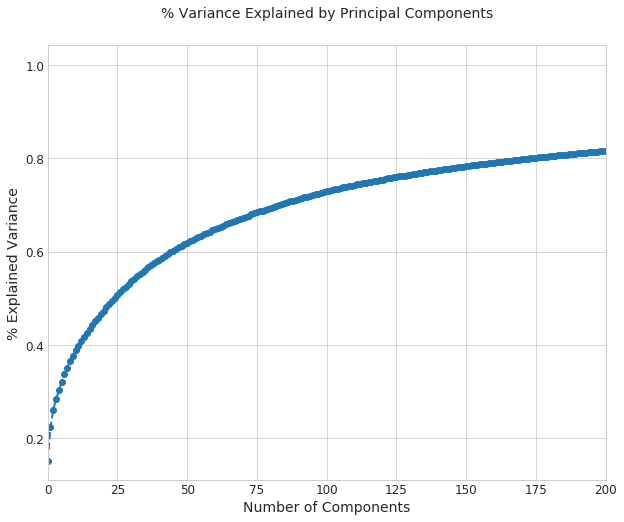

In [45]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [46]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0]

array([ 896,  897,  898, ..., 4947, 4948, 4949])

In [52]:
pca=PCA(n_components=200,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 896 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 896 components is: 0.8154971869


In [59]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [60]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,200).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.902631498142
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25116  2722    27838
True         449  4280     4729
__all__    25565  7002    32567

Accuracy of the model for test data is: 0.898305084746
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6237   703     6940
True         125  1077     1202
__all__     6362  1780     8142



Logistic Regression
Accuracy of the model for training data is: 0.888783124021
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24932  2906    27838
True         716  4013     4729
__all__    25648  6919    32567

Accuracy of the model for test data is: 0.890690248096
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6209   731     6940
True         159  1043     1202
__all__     6368  1774     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.914176927565
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25236  2602    27838
True         193  4536     4729
__all__    25429  7138    32567

Accuracy of the model for test data is: 0.90211250307
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6275   665     6940
True         132  1070     1202
__all__     6407  1735     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.89154665766
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25121  2717    27838
True         815  3914     4729
__all__    25936  6631    32567

Accuracy of the model for test data is: 0.891549987718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6258   682     6940
True         201  1001     1202
__all__     6459  1683     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.902570086284
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25247  2591    27838
True         582  4147     4729
__all__    25829  6738    32567

Accuracy of the model for test data is: 0.899533284205
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6281   659     6940
True         159  1043     1202
__all__     6440  1702     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.916602695981
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25251  2587    27838
True         129  4600     4729
__all__    25380  7187    32567

Accuracy of the model for test data is: 0.902972242692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6278   662     6940
True         128  1074     1202
__all__     6406  1736     8142



Bagging Classifier
Accuracy of the model for training data is: 0.914269045353
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25235  2603    27838
True         189  4540     4729
__all__    25424  7143    32567

Accuracy of the model for test data is: 0.900884303611
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6264   676     6940
True         131  1071     1202
__all__     6395  1747     8142



Neural Network-1
The accuracy of the model on training data is: 0.91000092118


Predicted  False  True  __all__
Actual                         
False      25038  2800    27838
True         131  4598     4729
__all__    25169  7398    32567

The accuracy of the model on test data is: 0.896831245394


Predicted  False  True  __all__
Actual                         
False       6205   735     6940
True         105  1097     1202
__all__     6310  1832     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [61]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [62]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.902631,4280.0,25116.0,2722.0,449.0,0.097780,0.094946
LogisticRegression,0.888783,4013.0,24932.0,2906.0,716.0,0.104390,0.151406
RandomForestClassifier,0.914177,4536.0,25236.0,2602.0,193.0,0.093469,0.040812
AdaBoostClassifier,0.891547,3914.0,25121.0,2717.0,815.0,0.097600,0.172341
GradientBoostingClassifier,0.902570,4147.0,25247.0,2591.0,582.0,0.093074,0.123070
ExtraTreeClassifier,0.916603,4600.0,25251.0,2587.0,129.0,0.092931,0.027278
BaggingClassifier,0.914269,4540.0,25235.0,2603.0,189.0,0.093505,0.039966
Neural Network-1,0.910001,4598.0,25038.0,2800.0,131.0,0.100582,0.027701


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.898305,1077.0,6237.0,703.0,125.0,0.101297,0.103993,0.897355,0.682077
LogisticRegression,0.890690,1043.0,6209.0,731.0,159.0,0.105331,0.132280,0.881195,0.655134
RandomForestClassifier,0.902113,1070.0,6275.0,665.0,132.0,0.095821,0.109817,0.897181,0.688134
AdaBoostClassifier,0.891550,1001.0,6258.0,682.0,201.0,0.098271,0.167221,0.867254,0.643434
GradientBoostingClassifier,0.899533,1043.0,6281.0,659.0,159.0,0.094957,0.132280,0.886382,0.674149
ExtraTreeClassifier,0.902972,1074.0,6278.0,662.0,128.0,0.095389,0.106489,0.899061,0.691246
BaggingClassifier,0.900884,1071.0,6264.0,676.0,131.0,0.097406,0.108985,0.896804,0.685759
Neural Network-1,0.896831,1097.0,6205.0,735.0,105.0,0.105908,0.087354,0.896804,0.685310


In [63]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')